# Checking bars 2.0

In [1]:
import re
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd 

In [64]:
def calc_rate(directory):
    """
    Calculates rates for data runs in a specified directory and returns
    a dictionary of results.

    Args:
        directory (str): The full path to the directory containing the run data files.

    Returns:
        dict: A dictionary where keys are the run numbers and values are dictionaries
              containing the 'Rate (Hz)', 'Run Type', and 'Status'. Returns an empty
              dictionary if no valid runs are found.
    """
    if not os.path.isdir(directory):
        print(f"Error: Directory not found: {directory}")
        return {}

    file_prefix = 'muons_run_'
    file_suffix = '.h5'
    hdf5_key = 'data'
    timestamp_column = 'timestamp'
    run_results = {}

    all_files = os.listdir(directory)
    
    # Filter for relevant run files and extract the run number
    run_files_info = []
    for filename in all_files:
        if filename.startswith(file_prefix) and filename.endswith(file_suffix):
            match = re.search(r'muons_run_(\d+)\.h5', filename)
            if match:
                run_number = int(match.group(1))
                run_type = 'No Source' if run_number % 2 != 0 else 'With Source'
                run_files_info.append({'filename': filename, 'run_number': run_number, 'type': run_type})

    run_files_info.sort(key=lambda x: x['run_number'])

    if not run_files_info:
        print(f"Warning: No valid run files found in {directory}.")
        return {}
        
    for file_info in run_files_info:
        run_num = file_info['run_number']
        file_name = file_info['filename']
        run_type = file_info['type']
        file_path = os.path.join(directory, file_name)

        try:
            data_df = pd.read_hdf(file_path, hdf5_key)

            if not data_df.empty and timestamp_column in data_df.columns:
                first_timestamp = data_df[timestamp_column].iloc[0]
                last_timestamp = data_df[timestamp_column].iloc[-1]
                num_rows = len(data_df)
                
                time_difference = (last_timestamp - first_timestamp) * 0.001
                
                if time_difference > 0:
                    rate = num_rows / time_difference
                    run_results[run_num] = {
                        'Rate (Hz)': f'{rate:.6f}', 
                        'Run Type': run_type, 
                        'Status': 'Success'
                    }
                else:
                    run_results[run_num] = {
                        'Rate (Hz)': 'N/A', 
                        'Run Type': run_type, 
                        'Status': 'Zero/Negative Time Diff'
                    }
            else:
                run_results[run_num] = {
                    'Rate (Hz)': 'N/A', 
                    'Run Type': run_type, 
                    'Status': 'Empty DataFrame or Timestamp Column Missing'
                }

        except KeyError:
            run_results[run_num] = {
                'Rate (Hz)': 'N/A', 
                'Run Type': run_type, 
                'Status': f"HDF5 Key '{hdf5_key}' Not Found"
            }
        except Exception as e:
            run_results[run_num] = {
                'Rate (Hz)': 'N/A', 
                'Run Type': run_type, 
                'Status': f'Error: {e}'
            }

    return run_results


def plot_rates(data_df, skip_bars=None):
    """
    Creates a scatter plot of the rates, grouped by run type.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the consolidated rates.
        skip_bars (list, optional): List of bar labels to exclude, e.g. ["B2", "C5"].
    """
    if data_df.empty:
        print("Cannot plot: The input DataFrame is empty.")
        return

    # Filter only successful rows
    plot_data = data_df[data_df['Status'] == 'Success'].copy()
    if plot_data.empty:
        print("No successful rates to plot.")
        return

    # Option to skip bars
    if skip_bars:
        plot_data = plot_data[~plot_data['Bar Label'].isin(skip_bars)]

    # Proper alphanumeric sorting
    plot_data = plot_data.sort_values(by=['Bar Letter', 'Bar Number'])

    # Separate data by run type
    no_source_data = plot_data[plot_data['Run Type'] == 'No Source']
    with_source_data = plot_data[plot_data['Run Type'] == 'With Source']

    # Plot
    plt.style.use('ggplot')
    plt.figure(figsize=(14, 8))

    plt.scatter(
        no_source_data['Bar Label'],
        no_source_data['Rate (Hz)'],
        color='blue',
        marker='o',
        label='Without Source'
    )

    plt.scatter(
        with_source_data['Bar Label'],
        with_source_data['Rate (Hz)'],
        color='red',
        marker='^',
        label='With Source'
    )

    plt.title('Muon Veto Rates for All Bars')
    plt.xlabel('Bar')
    plt.ylabel('Rate (Hz)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [72]:
base_directory = '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/'

final_rates_list = []
    
# Use os.walk to traverse the directory structure recursively
for root, dirs, files in os.walk(base_directory):
    # We only care about the directories one level below the 'bar' letter directories
    if os.path.basename(os.path.dirname(root)) in ['A', 'B', 'C', 'D', 'E', 'F']:
        bar_letter = os.path.basename(os.path.dirname(root))
        bar_number = os.path.basename(root)

        # Skip the base directory itself and any non-numeric subdirectories
        if bar_letter not in ['A', 'B', 'C', 'D', 'E', 'F'] or not bar_number.isdigit():
                continue

        #print(f"Processing directory: {root}")
            
        # Call the existing function to get rates for the current directory
        rates_dict = calc_rate(root)
            
        # Unpack the dictionary results and add bar information
        for run_num, data in rates_dict.items():
                run_entry = {
                        'Bar Letter': bar_letter,
                        'Bar Number': int(bar_number),   # keep numeric for sorting
                        'Bar Label': f"{bar_letter}{bar_number}",  # final label
                        'Run Number': run_num,
                        'Rate (Hz)': data['Rate (Hz)'],
                        'Run Type': data['Run Type'],
                        'Status': data['Status']
                        }
                final_rates_list.append(run_entry)
                
# Create a final DataFrame from the collected list of dictionaries
if final_rates_list:
        final_df = pd.DataFrame(final_rates_list)
        # Convert numeric columns for proper sorting and analysis
        final_df['Run Number'] = pd.to_numeric(final_df['Run Number'])
        final_df['Rate (Hz)'] = pd.to_numeric(final_df['Rate (Hz)'], errors='coerce')
        #print(final_df.sort_values(by=['Bar Letter', 'Bar Number', 'Run Number']).reset_index(drop=True))
else:
        print("No valid run data found in the specified directories.")
        #print(pd.DataFrame())    

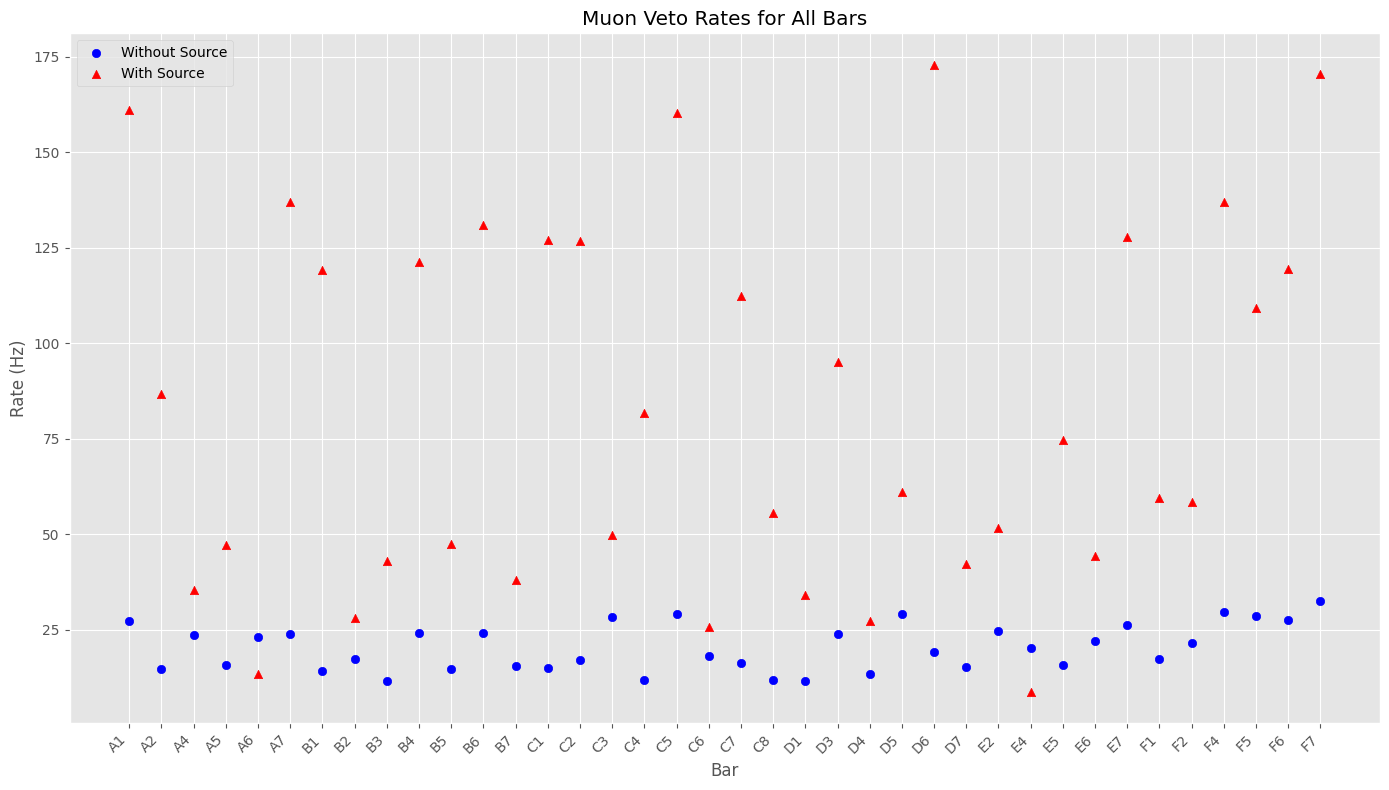

In [73]:
plot_rates(final_df, skip_bars=["D8", "E3", "A3"])

In [86]:
def plot_charge_histogram(h5_path, bar_label, run_type, pdf_pages):
    """
    Opens a single H5 file, reads charge data, and plots a histogram
    comparing channels 0, 6, and 7, saving it to a PDF object.

    Args:
        h5_path (str): The full path to the HDF5 file.
        bar_label (str): The label for the bar (e.g., "A4").
        run_type (str): The type of run ("Without Source" or "With Source").
        pdf_pages (PdfPages): The PDF object to save the plot to.
    """
    try:
        with h5py.File(h5_path, "r") as f:
            if 'charges' not in f:
                print(f"Warning: 'charges' dataset not found in {h5_path} for bar {bar_label}. Skipping.")
                return

            charges = f["charges"][:]

            if charges.size == 0 or charges.shape[1] < 8:
                print(f"Warning: No data or insufficient columns in {h5_path} for bar {bar_label}. Skipping.")
                return
                
            charge_ch0 = charges[:, 0]
            charge_ch6 = charges[:, 6]
            charge_ch7 = charges[:, 7]

            # Create a figure object for plotting
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.style.use('ggplot')

            bins = np.linspace(0, 5000, 100)

            ax.hist(charge_ch0, bins=bins, alpha=0.6, histtype='step' , linewidth= 1.5, label='Channel 0 (Control/Noise)')
            ax.hist(charge_ch6, bins=bins, alpha=0.6, histtype='step' , linewidth= 1.5,label='Channel 6 (Active)')
            ax.hist(charge_ch7, bins=bins, alpha=0.6, histtype='step' , linewidth= 1.5,label='Channel 7 (Active)')

            ax.set_title(f'Charge Distribution for Bar {bar_label} ({run_type})')
            ax.set_xlabel('Charge (ADC Counts)')
            ax.set_ylabel('Frequency (Counts)')
            
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True)
            
            plt.tight_layout()
            pdf_pages.savefig(fig)
            plt.close(fig)

    except Exception as e:
        print(f"An error occurred while plotting {h5_path}: {e}")

def process_bar_directory(directory, bar_label, pdf_pages):
    """
    Finds the two H5 files in a bar's directory and triggers the plotting for each.
    
    Args:
        directory (str): The full path to the bar's data directory.
        bar_label (str): The label for the bar (e.g., "A4").
        pdf_pages (PdfPages): The PDF object to pass to the plotting function.
    """
    h5_files = sorted([f for f in os.listdir(directory) if f.endswith('.h5') and f.startswith('muons_run_')])

    if len(h5_files) < 2:
        print(f"Warning: Expected 2 H5 files in {directory}, but found {len(h5_files)}. Skipping bar {bar_label}.")
        return

    path_no_source = os.path.join(directory, h5_files[0])
    path_with_source = os.path.join(directory, h5_files[1])

    print(f"--- Processing Bar: {bar_label} ---")
    
    # Plot for "Without Source"
    plot_charge_histogram(path_no_source, bar_label, "Without Source", pdf_pages)

    # Plot for "With Source"
    plot_charge_histogram(path_with_source, bar_label, "With Source", pdf_pages)


In [87]:
base_directory = '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/'
output_pdf_path = '/lhome/ific/v/villamil/muonveto/charge_histograms.pdf'

# --- NEW: Collect all directories first to sort them ---
bar_directories_to_process = []

for root, dirs, files in os.walk(base_directory):
    parent_dir_name = os.path.basename(os.path.dirname(root))
    
    if parent_dir_name in ['A', 'B', 'C', 'D', 'E', 'F']:
        bar_letter = parent_dir_name
        bar_number_str = os.path.basename(root)

        if bar_number_str.isdigit():
            bar_number_int = int(bar_number_str)
            bar_label = f"{bar_letter}{bar_number_str}"
            # Store letter, number, label, and path for robust sorting
            bar_directories_to_process.append((bar_letter, bar_number_int, bar_label, root))


bar_directories_to_process.sort()

with PdfPages(output_pdf_path) as pdf:
    print(f"Starting to process bars. Output will be saved to '{output_pdf_path}'")
    
    # Loop through the sorted list of bars
    for bar_letter, bar_number_int, bar_label, path in bar_directories_to_process:
        process_bar_directory(path, bar_label, pdf)

print(f"\nProcessing complete. All plots have been saved to '{output_pdf_path}'.")

Starting to process bars. Output will be saved to '/lhome/ific/v/villamil/muonveto/charge_histograms.pdf'
--- Processing Bar: A1 ---
--- Processing Bar: A2 ---
--- Processing Bar: A3 ---
--- Processing Bar: A4 ---
--- Processing Bar: A5 ---
--- Processing Bar: A6 ---
--- Processing Bar: A7 ---
--- Processing Bar: B1 ---
--- Processing Bar: B2 ---
--- Processing Bar: B3 ---
--- Processing Bar: B4 ---
--- Processing Bar: B5 ---
--- Processing Bar: B6 ---
--- Processing Bar: B7 ---
--- Processing Bar: C1 ---
--- Processing Bar: C2 ---
--- Processing Bar: C3 ---
--- Processing Bar: C4 ---
--- Processing Bar: C5 ---
--- Processing Bar: C6 ---
--- Processing Bar: C7 ---
--- Processing Bar: C8 ---
--- Processing Bar: D1 ---
--- Processing Bar: D3 ---
--- Processing Bar: D4 ---
--- Processing Bar: D5 ---
--- Processing Bar: D6 ---
--- Processing Bar: D7 ---
--- Processing Bar: D8 ---
--- Processing Bar: E2 ---
--- Processing Bar: E3 ---
--- Processing Bar: E4 ---
--- Processing Bar: E5 ---
---

## Testing

In [2]:
h5_path = f"/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/D/4/muons_run_43.h5"

myh5 = pd.read_hdf(h5_path, key='data')

In [3]:
myh5

,timestamp,card,eventT0,eventT1,overflowT0,overflowT1,t0,t1,lostBuffer,lostFGPA
0,1755694682642,85,0,0,1,1,624026501,624026501,0,0
1,1755694682642,85,0,0,1,1,631937790,631937790,0,0
2,1755694682693,85,0,0,1,1,637724979,637724979,0,0
3,1755694682693,85,0,0,1,1,647925704,647925704,0,0
4,1755694682693,85,0,0,1,1,649386772,649386772,0,0
...,...,...,...,...,...,...,...,...,...,...
25015,1755696559924,85,0,0,1,1,985020986,985020986,0,0
25016,1755696559924,85,0,0,1,1,1010380954,1010380954,0,0
25017,1755696560025,85,0,0,1,1,24075230,24075230,0,0
25018,1755696560075,85,0,0,1,1,72649738,72649738,0,0


In [36]:
# timestamps
ts = myh5["timestamp"]

# time span
dt = ts.max() - ts.min()
print(ts.min(), ts.max())
print(f"{dt/1e3}2 seconds")
N = len(ts)

print("Events:", N)
print("Δt (raw units):", dt)

dt_seconds = dt / 1e3  # if timestamp is in ns
rate = N / dt_seconds
print("Event rate [Hz]:", rate)

1755694682642 1755696560075
1877.4332 seconds
Events: 25020
Δt (raw units): 1877433
Event rate [Hz]: 13.326707264653386


In [4]:

h5_path = "/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/D/4/muons_run_43.h5"

with h5py.File(h5_path, "r") as f:
    # check available groups/datasets
    print(list(f.keys()))

    # load charges dataset
    charges = f["charges"][:]   # numpy array (24986 x 32)
    print(charges.shape, charges.dtype)

['charges', 'data']
(25020, 32) int16


In [5]:
charges_df = pd.DataFrame(charges, columns=[f"ch_{i}" for i in range(charges.shape[1])])

In [6]:
charges_df

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,ch_9,...,ch_22,ch_23,ch_24,ch_25,ch_26,ch_27,ch_28,ch_29,ch_30,ch_31
0,206,225,225,250,242,230,641,596,239,245,...,233,245,257,252,222,240,250,236,222,243
1,224,234,215,251,248,228,2092,821,243,242,...,239,239,250,252,209,250,247,242,248,238
2,260,255,186,238,268,255,880,715,271,263,...,343,276,271,258,176,218,264,241,341,286
3,257,253,259,256,221,236,1160,823,278,267,...,243,258,268,264,257,241,241,225,243,252
4,246,248,226,253,268,247,1876,552,260,254,...,290,255,271,256,224,240,264,241,286,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,226,272,241,244,252,217,623,1119,244,282,...,230,240,248,281,254,225,244,206,230,251
25016,222,230,246,260,254,230,621,850,239,240,...,230,231,251,249,288,262,248,237,232,236
25017,272,247,258,247,243,245,1007,532,288,250,...,243,258,311,255,260,239,236,248,246,259
25018,190,218,241,244,296,229,723,588,212,239,...,241,245,229,241,253,229,290,225,243,243


In [23]:
def _calculate_rate_for_file(h5_path):
    """Helper function to calculate the event rate from a single HDF5 file."""
    try:
        data_df = pd.read_hdf(h5_path, 'data')
        if data_df.empty or 'timestamp' not in data_df.columns:
            return 0.0

        # Timestamps are assumed to be in milliseconds, convert to seconds
        time_difference_sec = (data_df['timestamp'].iloc[-1] - data_df['timestamp'].iloc[0]) * 0.001
        
        if time_difference_sec > 0:
            rate = len(data_df) / time_difference_sec
            return rate
        else:
            return 0.0
    except Exception as e:
        print(f"Could not calculate rate for {os.path.basename(h5_path)}: {e}")
        return 0.0

def _plot_charge_histogram_for_file(h5_path, bar_label, run_type):
    """Helper function to plot the charge histogram from a single HDF5 file."""
    try:
        with h5py.File(h5_path, "r") as f:
            if 'charges' not in f:
                print(f"Warning: 'charges' dataset not found in {h5_path}.")
                return

            charges = f["charges"][:]
            if charges.size == 0 or charges.shape[1] < 8:
                print(f"Warning: No data or insufficient columns in {h5_path}.")
                return
                
            charge_ch0 = charges[:, 0]
            charge_ch6 = charges[:, 6]
            charge_ch7 = charges[:, 7]

            plt.style.use('ggplot')
            plt.figure(figsize=(12, 7))
            
            bins = np.linspace(150, 1200, 100)

            plt.hist(charge_ch0, bins=bins, alpha=0.6, histtype= 'step', linewidth = 2, label='Channel 0 (Control/Noise)')
            plt.hist(charge_ch6, bins=bins, alpha=0.6, histtype= 'step',linewidth = 2, label='Channel 6 (Active)')
            plt.hist(charge_ch7, bins=bins, alpha=0.6, histtype= 'step',linewidth = 2,label='Channel 7 (Active)')

            plt.title(f'Charge Distribution for Bar {bar_label} ({run_type})')
            plt.xlabel('Charge (ADC Counts)')
            plt.ylabel('Frequency (Counts)')
            plt.yscale('log') # Set y-axis to logarithmic scale
            plt.legend()
            plt.grid(True, which='both', linestyle='--')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"An error occurred while plotting charge histogram for {h5_path}: {e}")


def analyze_single_bar(bar_directory_path):
    """
    Analyzes a single muon bar by plotting its event rates and charge distributions
    for runs with and without a source.

    Args:
        bar_directory_path (str): The full path to the directory containing a bar's data files.
                                  (e.g., ".../data/A/1")
    """
    # --- 1. Validate Path and Find Files ---
    if not os.path.isdir(bar_directory_path):
        print(f"Error: Directory not found: {bar_directory_path}")
        return

    # Automatically determine bar label from path for titles (e.g., "A1")
    bar_number = os.path.basename(bar_directory_path)
    bar_letter = os.path.basename(os.path.dirname(bar_directory_path))
    bar_label = f"{bar_letter}{bar_number}"
    print(f"--- Analyzing Bar: {bar_label} ---")

    h5_files = sorted([f for f in os.listdir(bar_directory_path) if f.endswith('.h5') and f.startswith('muons_run_')])

    if len(h5_files) < 2:
        print(f"Error: Expected 2 H5 files in {bar_directory_path}, but found {len(h5_files)}.")
        return

    path_no_source = os.path.join(bar_directory_path, h5_files[0])
    path_with_source = os.path.join(bar_directory_path, h5_files[1])
    
    # --- 2. Calculate and Plot Rates ---
    print("Calculating event rates...")
    rate_no_source = _calculate_rate_for_file(path_no_source)
    rate_with_source = _calculate_rate_for_file(path_with_source)

    # Plotting the rates
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    
    run_types = ['Without Source', 'With Source']
    rates = [rate_no_source, rate_with_source]
    
    bars = plt.bar(run_types, rates, color=['blue', 'red'])
    plt.ylabel('Rate (Hz)')
    plt.title(f'Event Rates for Bar {bar_label}')
    
    # Add rate values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f} Hz', va='bottom', ha='center')

    plt.tight_layout()
    plt.show()

    # --- 3. Plot Charge Distributions ---
    print("Generating charge distribution plots...")
    # Plot for "Without Source"
    _plot_charge_histogram_for_file(path_no_source, bar_label, "Without Source")

    # Plot for "With Source"
    _plot_charge_histogram_for_file(path_with_source, bar_label, "With Source")
    
    print(f"--- Analysis for Bar {bar_label} Complete ---")


--- Analyzing Bar: 7 ---
Calculating event rates...


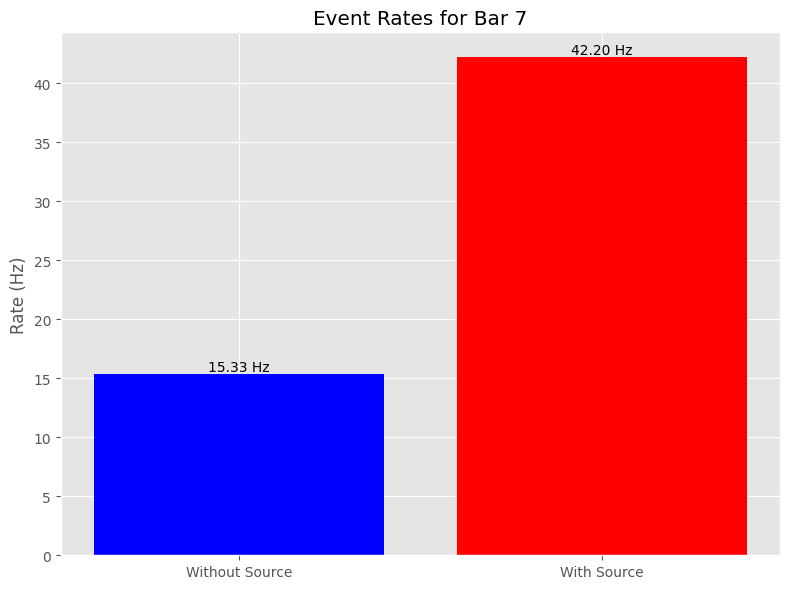

Generating charge distribution plots...


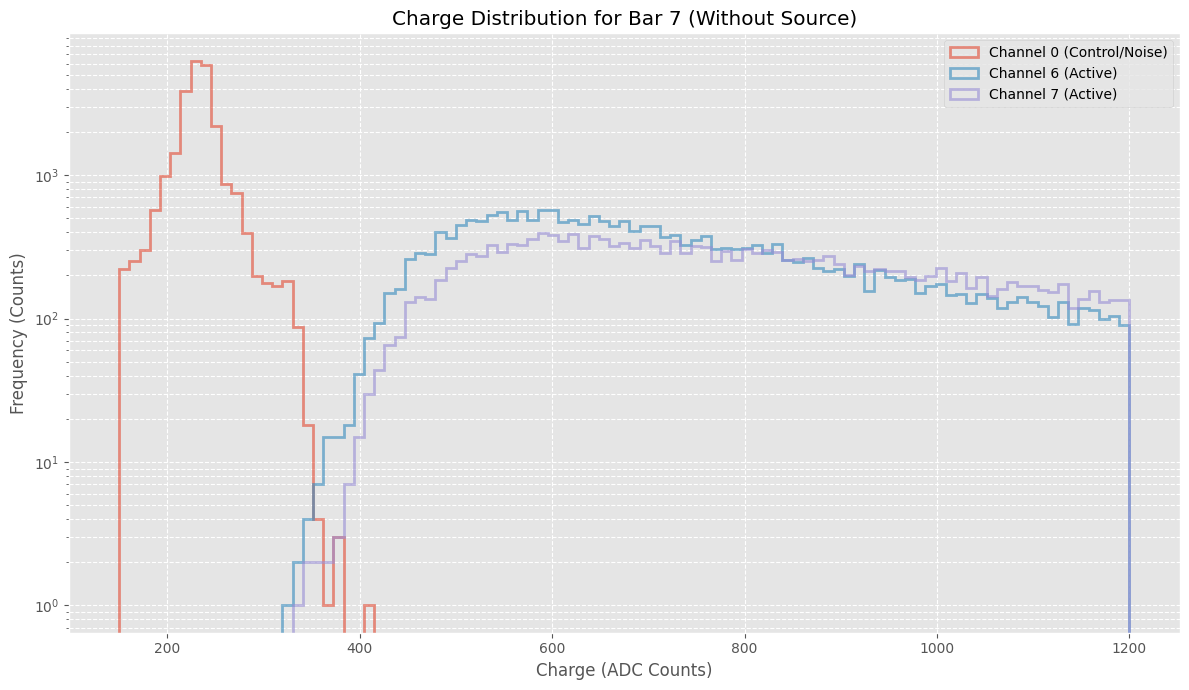

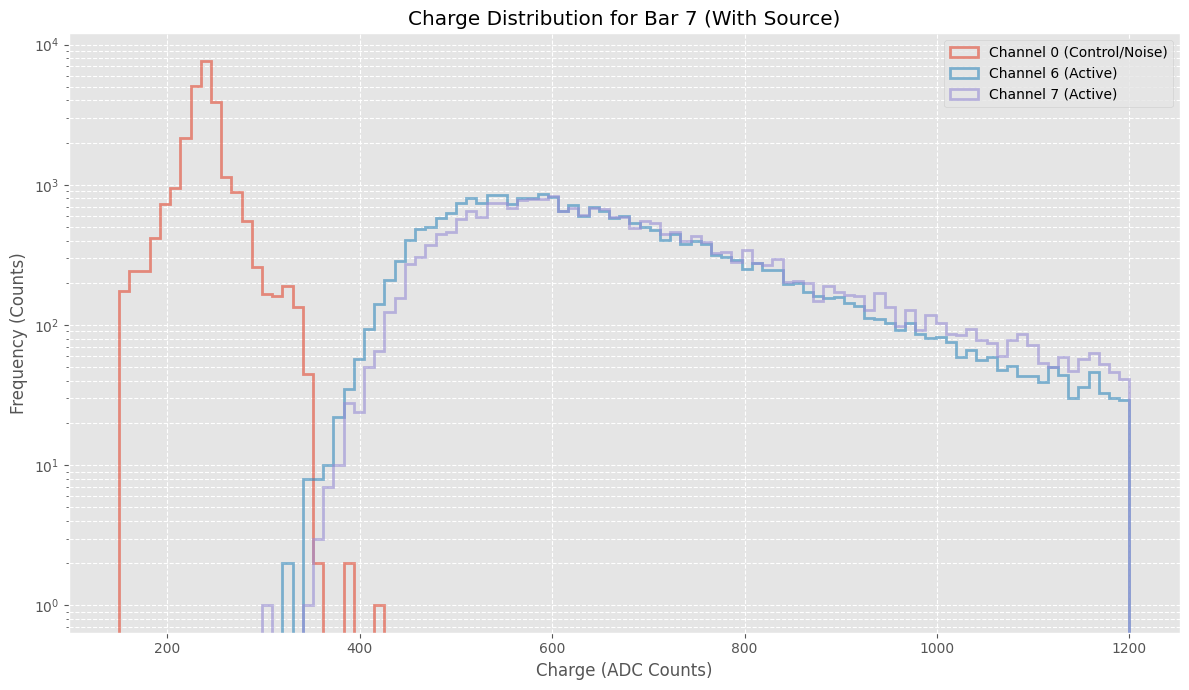

--- Analysis for Bar 7 Complete ---


In [24]:
bar_directory_path = '/lhome/ific/c/ccortesp/Analysis/Muon_Veto/data/D/7/'
analyze_single_bar(bar_directory_path)

--- Analyzing Bar: muonvetoD7 ---
Calculating event rates...


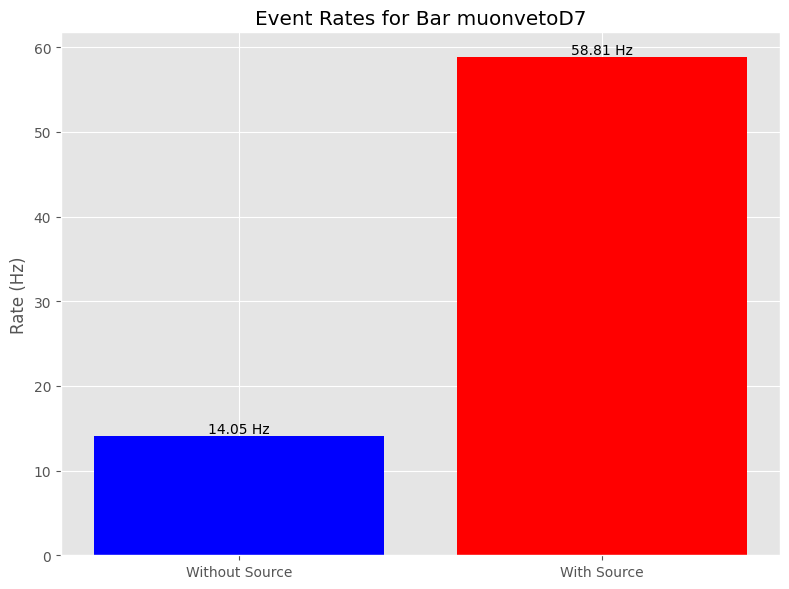

Generating charge distribution plots...


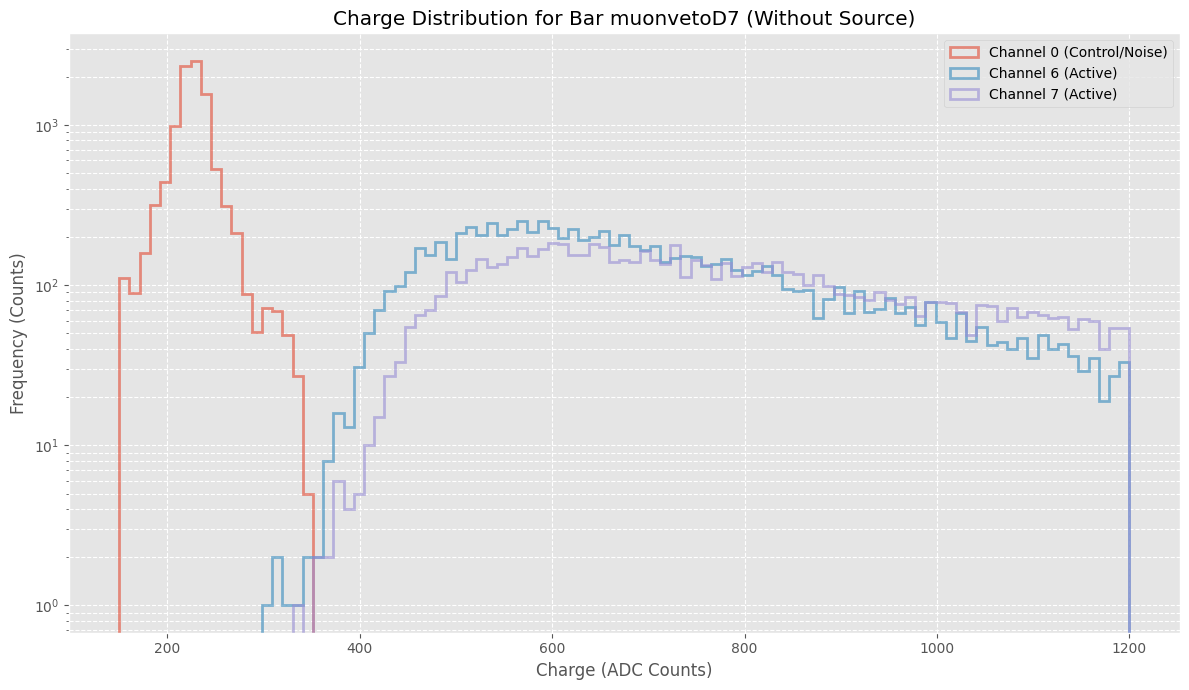

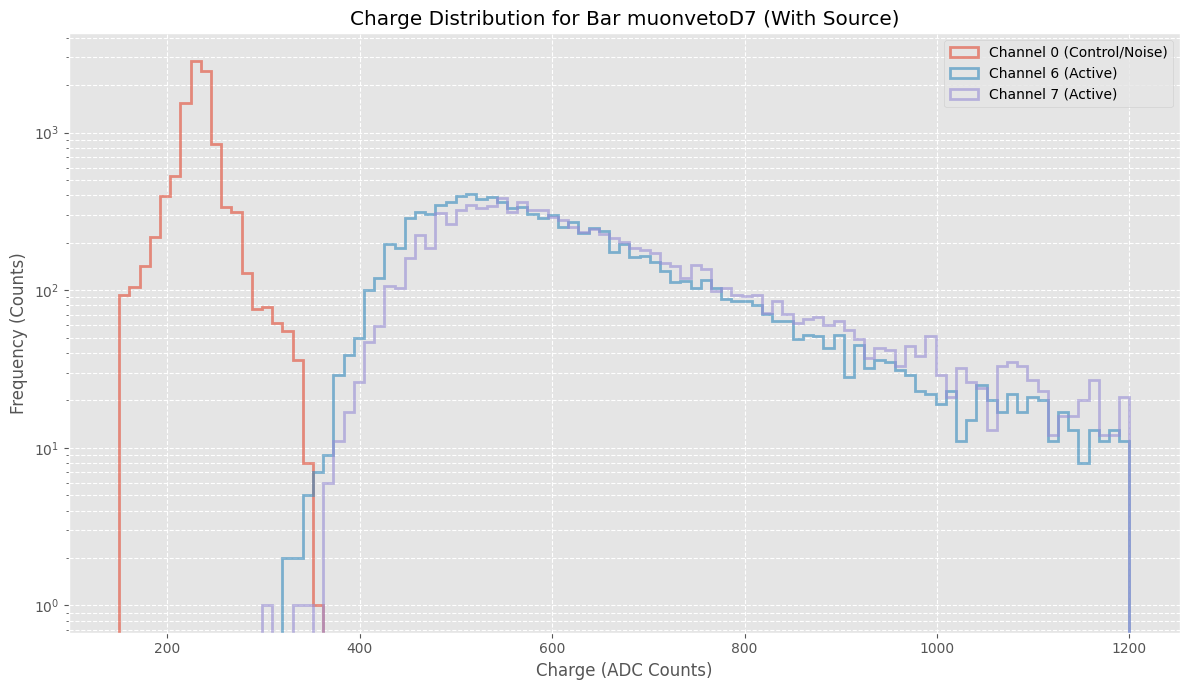

--- Analysis for Bar muonvetoD7 Complete ---


In [22]:
bar_directory_path = '/lhome/ific/v/villamil/muonveto/D7'
analyze_single_bar(bar_directory_path)